# 资产风险平价和因子风险平价

In [15]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm
from sklearn.decomposition import PCA

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

In [16]:
# 回测参数
date_range = [datetime(2015,1,1), datetime(2021,12,31)]
frequency = 22 
look_back = 252*1

## 1. 载入资产和因子数据

In [17]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')

# 读入因子数据
factor_data_raw = getFactorData().reindex(asset_data_raw.index).fillna(method='ffill').rolling(22).mean()

## 2. 资产风险平价

In [18]:
class AssetRiskParityStrategy(Strategy):
    def run(self, id_date, asset_data):
        w0 = [1/asset_data.shape[1]] * asset_data.shape[1]
        asset_cov = np.matrix(asset_data.pct_change().cov()*252)

        # opt
        cons = [] 
        cons.append({'type': 'eq', 'fun': lambda w: sum(w)-1})
        bounds = tuple([(0,1)] * asset_data.shape[1])

        asset_weights = minimize(self.riskLoss, w0, constraints=cons, args=(asset_cov), bounds=bounds,  method='SLSQP').x
        # sys.exit(1)
        return pd.Series(asset_weights, index=asset_data.columns).T

    def riskLoss(self, w, asset_cov):
        w = np.matrix(w).T
        # print(self.getAssetRisk(w, asset_cov).squeeze().round(3), self.getProtfolioRisk(w, asset_cov))
        return ((self.getAssetRisk(w, asset_cov) - self.getProtfolioRisk(w, asset_cov)/w.shape[0]) ** 2).sum()

    def getProtfolioRisk(self, w, asset_cov):
        return np.sqrt(w.T @ asset_cov @ w)[0,0]

    def getAssetRisk(self, w, asset_cov):
        return np.array(w) * (np.array(asset_cov @ w)) / self.getProtfolioRisk(w, asset_cov)

In [19]:
asset_risk_party_backtest = BacktestManager(
        AssetRiskParityStrategy(), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = frequency, 
        look_back = look_back, 
    )
asset_risk_party_backtest.run()

100%|██████████| 1705/1705 [00:10<00:00, 159.17it/s]


<AxesSubplot:>

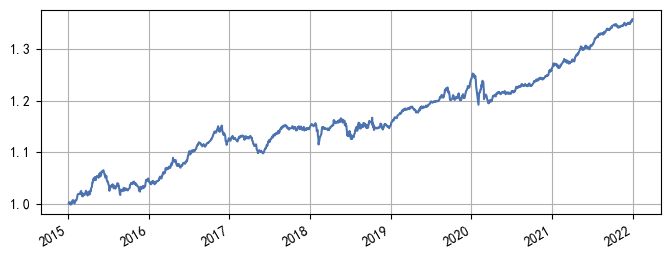

In [20]:
asset_risk_party_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

## 3. 因子风险平价

In [53]:
class FactorRiskParityStrategy(Strategy):
    def __init__(self, use_pca_factor=False, factor_data=None, pca_n_components=5):
        self._use_pca_factor = use_pca_factor
        self._factor_data = factor_data
        self._pca_n_components = pca_n_components

        if not use_pca_factor:
            self._factor_risk = pd.DataFrame(columns=factor_data.columns)
        else:
            self._factor_risk = pd.DataFrame(columns=['factor_{}'.format(i) for i in range(self._pca_n_components)])

    def getPcaFactorReturns(self, asset_data):
        asset_data = asset_data.rolling(22).mean().dropna()
        asset_return = asset_data.pct_change().fillna(0)

        pca=PCA(n_components=self._pca_n_components)  
        asset_return_pca = pca.fit_transform(asset_return)
        asset_return_pca = pd.DataFrame(asset_return_pca)

        asset_return_pca.index = asset_data.index
        asset_return_pca.columns = ['factor_{}'.format(i) for i in range(asset_return_pca.shape[1])]

        return asset_return_pca

    def getProtfolioRisk(self, w, asset_cov):
        return np.sqrt(w.T @ asset_cov @ w)[0,0]

    def riskLoss(self, w, asset_cov, A_T, A_pinv):
        w = np.matrix(w).T
        # print(self.getFactorRisk(w, asset_cov, A_T, A_pinv).squeeze().round(5), self.getProtfolioRisk(w, asset_cov))
        return ((self.getFactorRisk(w, asset_cov, A_T, A_pinv) - self.getProtfolioRisk(w, asset_cov)/A_T.shape[0]) ** 2).sum()

    def getProtfolioRisk(self, w, asset_cov):
        return np.sqrt(w.T @ asset_cov @ w)[0,0]

    def getFactorRisk(self, w, asset_cov, A_T, A_pinv):
        return np.array(A_T @ w) * np.array(A_pinv @ asset_cov @ w) / self.getProtfolioRisk(w, asset_cov)

    def run(self, id_date, asset_data):
        if self._use_pca_factor:
            factor_returns = self.getPcaFactorReturns(asset_data)
        else:
            factor_returns = self._factor_data.reindex(asset_data.index).rolling(22).mean().dropna().pct_change().fillna(0)
        asset_returns = asset_data.pct_change().reindex(factor_returns.index)

        w0 = [1/asset_data.shape[1]] * asset_data.shape[1]
        asset_cov = np.matrix(asset_data.pct_change().cov()*252)

        A = getFatorExposureFrame(asset_returns, factor_returns, norm=False)
        A_T = np.matrix(A).T
        A_pinv = np.linalg.pinv(np.matrix(A))

        # opt
        cons = [] 
        cons.append({'type': 'eq', 'fun': lambda w: sum(w)-1})
        # bounds = tuple([(-1,1)] * asset_data.shape[1])
        bounds = tuple([(0,1)] * asset_data.shape[1])

        asset_weights = minimize(self.riskLoss, w0, constraints=cons, args=(asset_cov, A_T, A_pinv), bounds=bounds,  method='SLSQP').x

        self._factor_risk.loc[id_date] = np.array(self.getFactorRisk(asset_weights, asset_cov, A_T, A_pinv)).squeeze()
        # print(self.getFactorRisk(asset_weights, asset_cov, A_T, A_pinv))
        # sys.exit(1)

        return pd.Series(asset_weights, index=asset_data.columns).T


        

        
            

In [54]:
factor_risk_party_backtest_pca = BacktestManager(
        FactorRiskParityStrategy(use_pca_factor=True), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = frequency, 
        look_back = look_back, 
    )
factor_risk_party_backtest_pca.run()

  0%|          | 0/1705 [00:00<?, ?it/s]


TypeError: minimize() got an unexpected keyword argument 'maxiter'

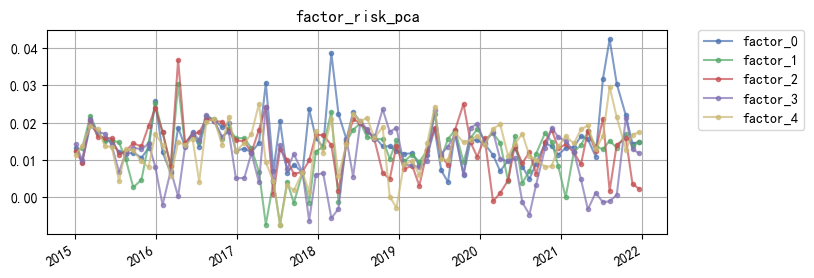

In [50]:
factor_risk_party_backtest_pca._strategy._factor_risk.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-', title='factor_risk_pca')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

<AxesSubplot:>

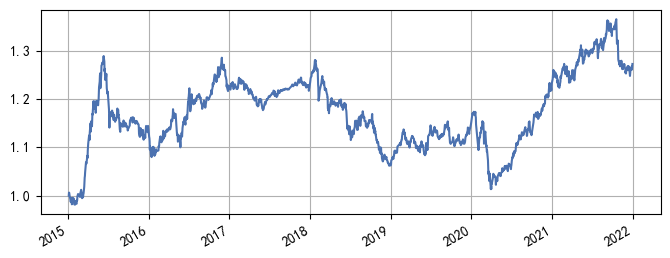

In [51]:
factor_risk_party_backtest_pca.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

In [52]:
factor_risk_party_backtest = BacktestManager(
        FactorRiskParityStrategy(factor_data=factor_data_raw), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = frequency, 
        look_back = look_back, 
    )
factor_risk_party_backtest.run()

100%|██████████| 1705/1705 [00:15<00:00, 109.95it/s]


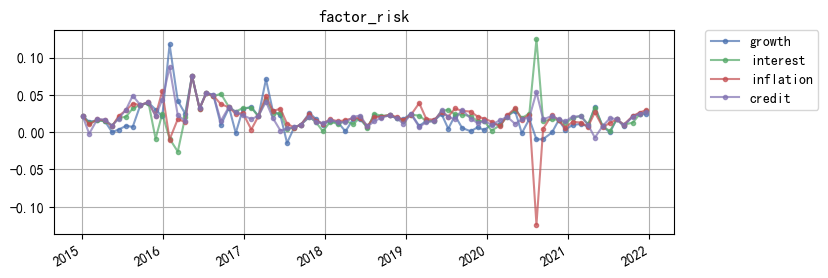

In [26]:
factor_risk_party_backtest._strategy._factor_risk.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-', title='factor_risk')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

<AxesSubplot:>

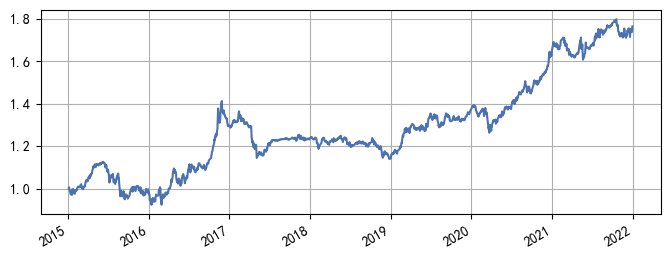

In [27]:
factor_risk_party_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

## 4. 等权重

In [28]:
class EqualWeightStrategy(Strategy):
    def run(self, id_date, asset_data): 
        return pd.Series([1/asset_data.shape[1]]*asset_data.shape[1], index=asset_data.columns)


In [29]:
equal_weight_backtest = BacktestManager(
        EqualWeightStrategy(), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = frequency, 
        look_back = look_back, 
    )
equal_weight_backtest.run()

100%|██████████| 1705/1705 [00:08<00:00, 208.54it/s]


<AxesSubplot:>

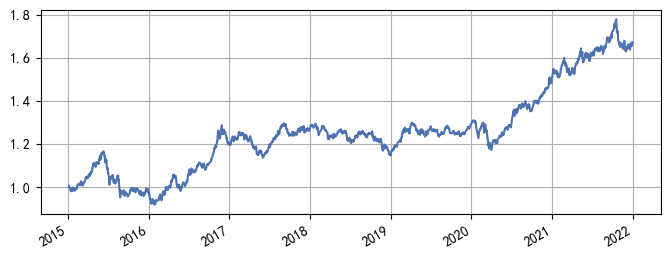

In [30]:
equal_weight_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

## 5. 资产风险平价和因子风险平价对比

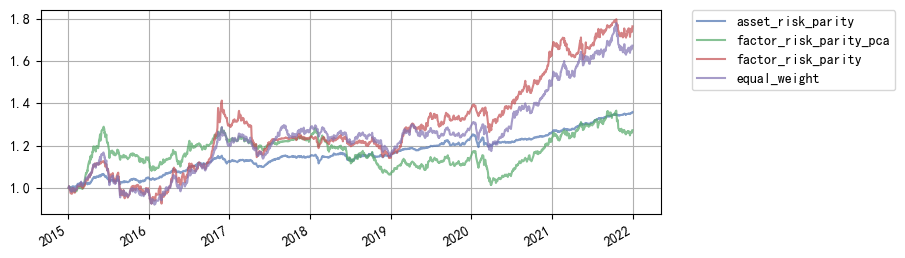

In [31]:
rp_values = pd.DataFrame({
    'asset_risk_parity': asset_risk_party_backtest.getHistoricalValue(scale=True), 
    'factor_risk_parity_pca': factor_risk_party_backtest_pca.getHistoricalValue(scale=True), 
    'factor_risk_parity': factor_risk_party_backtest.getHistoricalValue(scale=True), 
    'equal_weight': equal_weight_backtest.getHistoricalValue(scale=True), 
})
rp_values.plot(figsize=(8,3), grid=True, alpha=0.7)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [32]:
# sharpe
sharpe = ((rp_values.iloc[-1]/rp_values.iloc[0]) ** (252/rp_values.shape[0]) - 1 - 0.015) / (rp_values.pct_change().std() * 252**0.5)
sharpe


asset_risk_parity         0.892913
factor_risk_parity_pca    0.241258
factor_risk_parity        0.660522
equal_weight              0.612056
dtype: float64